# Multiple LSTMs

In this lab, you will look at how to build a model with multiple LSTM layers. Since you know the preceding steps already (e.g. downloading datasets, preparing the data, etc.), we won't expound on it anymore so you can just focus on the model building code.

## Imports

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import keras_nlp

## Load and Prepare the Dataset

In [2]:
# The dataset is already downloaded for you. For downloading you can use the code below.
imdb = tfds.load("imdb_reviews", as_supervised=True, data_dir="../data/", download=False)

In [3]:
# Extract the train reviews and labels
train_reviews = imdb['train'].map(lambda review, label: review)
train_labels = imdb['train'].map(lambda review, label: label)

# Extract the test reviews and labels
test_reviews = imdb['test'].map(lambda review, label: review)
test_labels = imdb['test'].map(lambda review, label: label)

In [ ]:
# Download the subword vocabulary (not needed in Coursera)
# !wget -nc https://storage.googleapis.com/tensorflow-1-public/course3/imdb_vocab_subwords.txt

In [4]:
# Initialize the subword tokenizer
subword_tokenizer = keras_nlp.tokenizers.WordPieceTokenizer(
    vocabulary='./imdb_vocab_subwords.txt'
)

Like the previous lab, we increased the `BATCH_SIZE` here to make the training faster. If you are doing this on your local machine and have a powerful processor, feel free to use the value used in the lecture (i.e. 64) to get the same results as Laurence.

In [5]:
# Data pipeline and padding parameters
SHUFFLE_BUFFER_SIZE = 10000
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE
BATCH_SIZE = 256
PADDING_TYPE = 'pre'
TRUNC_TYPE = 'post'

In [6]:
def padding_func(sequences):
  '''Generates padded sequences from a tf.data.Dataset'''

  # Put all elements in a single ragged batch
  sequences = sequences.ragged_batch(batch_size=sequences.cardinality())

  # Output a tensor from the single batch
  sequences = sequences.get_single_element()

  # Pad the sequences
  padded_sequences = tf.keras.utils.pad_sequences(sequences.numpy(), 
                                                  truncating=TRUNC_TYPE, 
                                                  padding=PADDING_TYPE
                                                 )

  # Convert back to a tf.data.Dataset
  padded_sequences = tf.data.Dataset.from_tensor_slices(padded_sequences)

  return padded_sequences

In [7]:
# Generate integer sequences using the subword tokenizer
train_sequences_subword = train_reviews.map(lambda review: subword_tokenizer.tokenize(review)).apply(padding_func)
test_sequences_subword = test_reviews.map(lambda review: subword_tokenizer.tokenize(review)).apply(padding_func)

# Combine the integer sequence and labels
train_dataset_vectorized = tf.data.Dataset.zip(train_sequences_subword,train_labels)
test_dataset_vectorized = tf.data.Dataset.zip(test_sequences_subword,test_labels)

# Optimize the datasets for training
train_dataset_final = (train_dataset_vectorized
                       .shuffle(SHUFFLE_BUFFER_SIZE)
                       .cache()
                       .prefetch(buffer_size=PREFETCH_BUFFER_SIZE)
                       .batch(BATCH_SIZE)
                       )

test_dataset_final = (test_dataset_vectorized
                      .cache()
                      .prefetch(buffer_size=PREFETCH_BUFFER_SIZE)
                      .batch(BATCH_SIZE)
                      )

## Build and Compile the Model

You can build multiple layer LSTM models by simply appending another `LSTM` layer in your `Sequential` model and enabling the `return_sequences` flag to `True`. This is because an `LSTM` layer expects a sequence input so if the previous layer is also an LSTM, then it should output a sequence as well. See the code cell below that demonstrates this flag in action. You'll notice that the output dimension is in 3 dimensions `(batch_size, timesteps, features)` when `return_sequences` is True.

In [8]:
# Parameters
BATCH_SIZE = 1
TIMESTEPS = 20
FEATURES = 16
LSTM_DIM = 8

print(f'batch_size: {BATCH_SIZE}')
print(f'timesteps (sequence length): {TIMESTEPS}')
print(f'features (embedding size): {FEATURES}')
print(f'lstm output units: {LSTM_DIM}')

# Define array input with random values
random_input = np.random.rand(BATCH_SIZE, TIMESTEPS, FEATURES)
print(f'shape of input array: {random_input.shape}')

# Define LSTM that returns a single output
lstm = tf.keras.layers.LSTM(LSTM_DIM)
result = lstm(random_input)
print(f'shape of lstm output(return_sequences=False): {result.shape}')

# Define LSTM that returns a sequence
lstm_rs = tf.keras.layers.LSTM(LSTM_DIM, return_sequences=True)
result = lstm_rs(random_input)
print(f'shape of lstm output(return_sequences=True): {result.shape}')

batch_size: 1
timesteps (sequence length): 20
features (embedding size): 16
lstm output units: 8
shape of input array: (1, 20, 16)
shape of lstm output(return_sequences=False): (1, 8)
shape of lstm output(return_sequences=True): (1, 20, 8)


The next cell implements the stacked LSTM architecture.

In [9]:
# Model parameters
EMBEDDING_DIM = 64
LSTM1_DIM = 32
LSTM2_DIM = 16
DENSE_DIM = 64

# Build the model
model = tf.keras.Sequential([
    tf.keras.Input(shape=(None,)),
    tf.keras.layers.Embedding(subword_tokenizer.vocabulary_size(), EMBEDDING_DIM),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(LSTM1_DIM, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(LSTM2_DIM)),
    tf.keras.layers.Dense(DENSE_DIM, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Print the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, None, 64)       │       488,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, None, 64)       │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 32)             │        10,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 526,017 (2.01 MB)

 Trainable params: 526,017 (2.01 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Set the training parameters
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

## Train the Model

The additional LSTM layer will lengthen the training time compared to the previous lab. Given the default parameters, it will take around 2 minutes per epoch in your lab environment. Also, since this is a larger model, it might start to overfit quickly so you may want to use fewer epochs or use a callback to monitor the validation accuracy.

In [11]:
NUM_EPOCHS = 5

# Train the model
history = model.fit(train_dataset_final, epochs=NUM_EPOCHS, validation_data=test_dataset_final)

Epoch 1/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 57s 539ms/step - accuracy: 0.6169 - loss: 0.6230 - val_accuracy: 0.8368 - val_loss: 0.3773
Epoch 2/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 52s 535ms/step - accuracy: 0.8770 - loss: 0.2979 - val_accuracy: 0.8740 - val_loss: 0.3123
Epoch 3/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 52s 535ms/step - accuracy: 0.9045 - loss: 0.2430 - val_accuracy: 0.8310 - val_loss: 0.5174
Epoch 4/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 52s 534ms/step - accuracy: 0.9073 - loss: 0.2425 - val_accuracy: 0.8451 - val_loss: 0.4178
Epoch 5/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 52s 534ms/step - accuracy: 0.9382 - loss: 0.1746 - val_accuracy: 0.8431 - val_loss: 0.4331


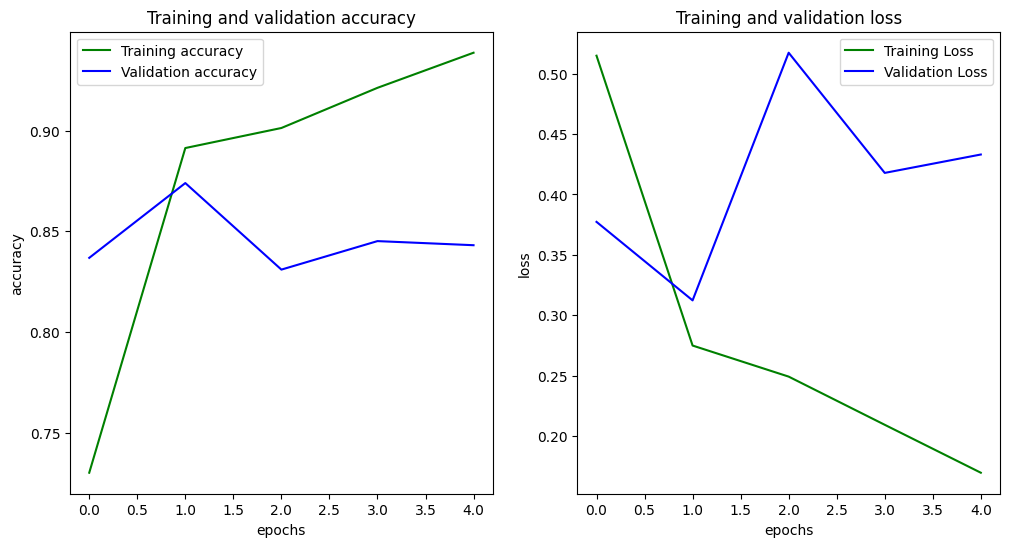

In [13]:
def plot_loss_acc(history):
  '''Plots the training and validation loss and accuracy from a history object'''
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  fig, ax = plt.subplots(1,2, figsize=(12, 6))
  ax[0].plot(epochs, acc, 'g', label='Training accuracy')
  ax[0].plot(epochs, val_acc, 'b', label='Validation accuracy')
  ax[0].set_title('Training and validation accuracy')
  ax[0].set_xlabel('epochs')
  ax[0].set_ylabel('accuracy')
  ax[0].legend()

  ax[1].plot(epochs, loss, 'g', label='Training Loss')
  ax[1].plot(epochs, val_loss, 'b', label='Validation Loss')
  ax[1].set_title('Training and validation loss')
  ax[1].set_xlabel('epochs')
  ax[1].set_ylabel('loss')
  ax[1].legend()

  plt.show()

plot_loss_acc(history)

## Wrap Up

This lab showed how you can build deep networks by stacking LSTM layers. In the next labs, you will continue exploring other architectures you can use to implement your sentiment classification model. 

As before, run the cell below to free up resources.

In [ ]:
# Shutdown the kernel to free up resources. 
# Note: You can expect a pop-up when you run this cell. You can safely ignore that and just press `Ok`.

from IPython import get_ipython

k = get_ipython().kernel

k.do_shutdown(restart=False)